In [2]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [3]:
# we generate a random graph for edge prediction as a demonstration.

src = np.random.randint(0, 100, 500)
dst = np.random.randint(0, 100, 500)
# make it symmetric
edge_pred_graph = dgl.graph((np.concatenate([src, dst]), np.concatenate([dst, src])))
# synthetic node and edge features, as well as edge labels
edge_pred_graph.ndata['feature'] = torch.randn(100, 10)
edge_pred_graph.edata['feature'] = torch.randn(1000, 10)
edge_pred_graph.edata['label'] = torch.randn(1000)
# synthetic train-validation-test splits
edge_pred_graph.edata['train_mask'] = torch.zeros(1000, dtype=torch.bool).bernoulli(0.6)

In [9]:
edge_pred_graph.edata['feature'][1]

tensor([ 0.6554,  0.1897,  1.8361,  0.0530, -0.3010, -0.2195, -1.1381,  0.1352,
         0.8161,  0.1082])

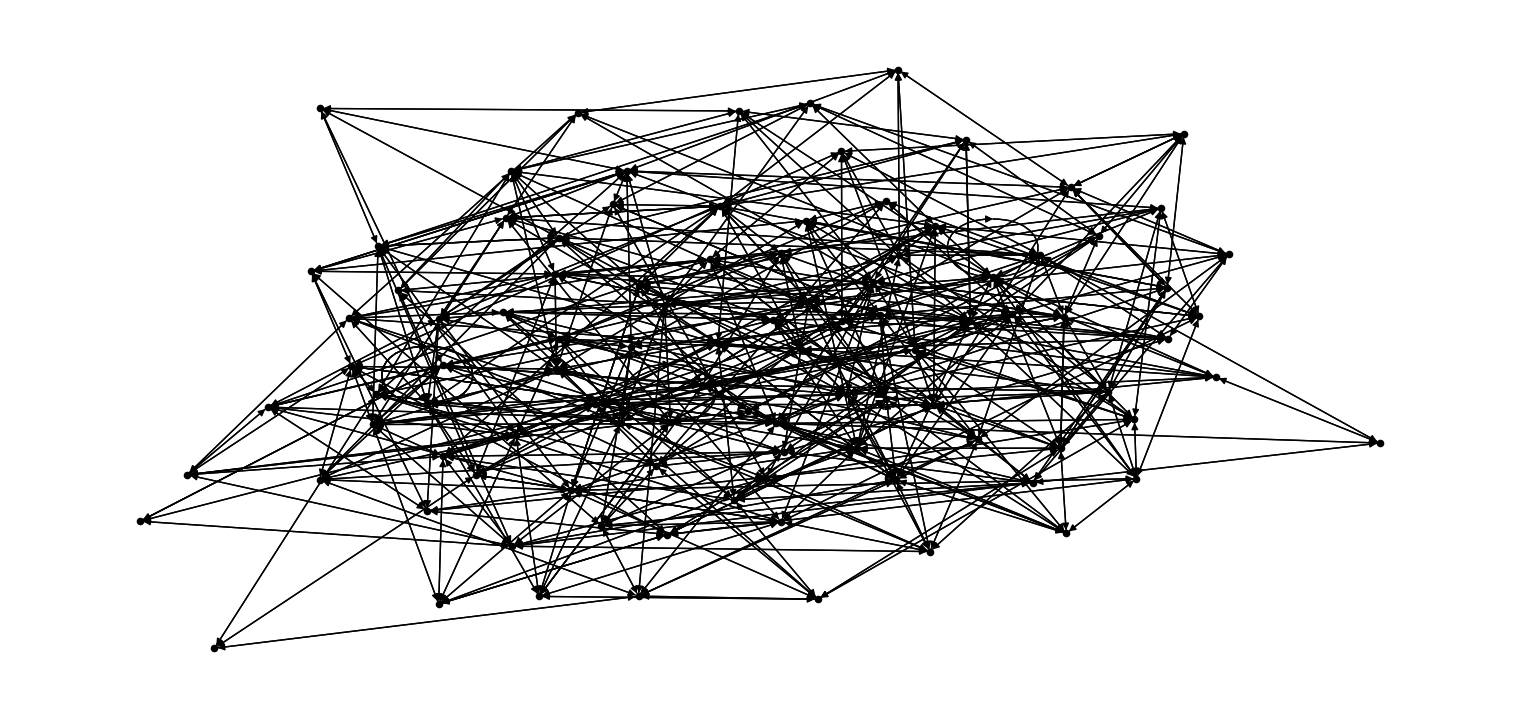

In [10]:
import dgl.data
import matplotlib.pyplot as plt
import networkx as nx

#dataset = dgl.data.CoraGraphDataset()
g = edge_pred_graph
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw(G, **options)

In [5]:
import dgl.function as fn
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

In [6]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [13]:
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [15]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

In [17]:
node_features = edge_pred_graph.ndata['feature']
edge_label = edge_pred_graph.edata['label']
train_mask = edge_pred_graph.edata['train_mask']
model = Model(10, 20, 5)
opt = torch.optim.Adam(model.parameters())
for epoch in range(300):
    pred = model(edge_pred_graph, node_features)
    loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

116.28304290771484
109.05999755859375
102.29857635498047
95.97308349609375
90.0668716430664
84.56595611572266
79.44937133789062
74.69567108154297
70.28462219238281
66.19464874267578
62.40544128417969
58.89539337158203
55.64450454711914
52.63401794433594
49.84705352783203
47.26655578613281
44.874637603759766
42.6580696105957
40.603553771972656
38.696598052978516
36.928226470947266
35.283897399902344
33.75382614135742
32.32912826538086
31.001190185546875
29.760059356689453
28.598628997802734
27.510705947875977
26.490453720092773
25.532888412475586
24.63275146484375
23.785823822021484
22.98836898803711
22.23586654663086
21.52520751953125
20.853363037109375
20.217281341552734
19.614490509033203
19.042882919311523
18.50006675720215
17.984088897705078
17.49308204650879
17.025394439697266
16.5797061920166
16.154523849487305
15.748266220092773
15.360124588012695
14.989075660705566
14.633970260620117
14.293686866760254
13.967497825622559
13.654516220092773
13.354131698608398
13.06558895111084
1